<h1>CS4618: Artificial Intelligence I</h1>
<h1>Accuracy Estimation</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier

# Class, for use in pipelines, to select certain columns from a DataFrame and convert to a numpy array
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly, 2017
# Modified by Derek Bridge to allow for casting in the same ways as pandas.DataFrame.astype
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values

<h1>The CS1109 Dataset</h1>

In [4]:
df = pd.read_csv("datasets/dataset_cs1109.csv")

df = df.take(np.random.permutation(len(df)))

y = df["outcome"].values

In [5]:
# The features we want to select
features = ["lect", "lab", "cao"]

# Create the pipeline
pipeline = Pipeline([
        ("selector", DataFrameSelector(features, "float64")),
        ("scaler", StandardScaler()),
        ("estimator", LogisticRegression())
    ])

<h1>Evaluation Methods for Classification</h1>
<ul>
    <li>Holdout (and many other methods) rely on <em>randomly</em>
        partitioning the dataset into a training set and a test set
        <ul>
            <li>We've discussed before that the split may be 'lucky' or 'unlucky', hence resampling methods
                such as $k$-Fold Cross-Validation
            </li>
        </ul>
    <li>In the case of classification, for example, the split might not reflect
        the distribution of examples within the classes:
        <ul>
            <li>Examples of one class might be under-represented in the training set or test set</li>
            <li>Examples of one class might even be completely absent from the training set or test set</li>
        </ul>
    </li>
    <li><b>Stratification</b> is the solution to this: 
        <ul>
            <li>In stratification, the proportion of examples of each class in the overall dataset is respected 
                in the partitioning into training and test sets
            </li>
            <li>Here's pseudocode for <b>stratified holdout</b>. For simplicity, the pseudocode only 
                covers the case of binary classification:
                <ul style="background: lightgray">
                    <li>Divide the dataset into positive examples, $P$, and negative examples, $N$</li>
                    <li>Randomly partition $P$ into $\mathit{Train}_P$ and $\mathit{Test}_P$</li>
                    <li>Randomly partition $N$ into $\mathit{Train}_N$ and $\mathit{Test}_N$</li>
                    <li>$\mathit{Train} \gets \mathit{Train}_P \cup \mathit{Train}_N$</li>
                    <li>$\mathit{Test} \gets \mathit{Test}_P \cup \mathit{Test}_N$</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>Although this fixes the distribution with respect to the classes, you may still get 'lucky' or 'unlucky' 
        in other ways, so you will still want to do the above multiple times, e.g. <b>Stratified 
        $k$-Fold Cross-Validation</b>
    </li>
</ul>

<h1>Stratification in scikit-learn</h1>

In [6]:
# Stratified holdout

ss = StratifiedShuffleSplit(n_splits=1, train_size=0.8)

np.mean(cross_val_score(pipeline, df, y, scoring="accuracy", cv=ss))

0.7142857142857143

In [7]:
# Compare the following, which doesn't use stratification, to the above, which does

ss = ShuffleSplit(n_splits=1, train_size=0.8)

np.mean(cross_val_score(pipeline, df, y, scoring="accuracy", cv=ss))

0.88571428571428568

In [8]:
# Stratified k-fold cross-validation

kf = StratifiedKFold(n_splits = 10)
np.mean(cross_val_score(pipeline, df, y, scoring="accuracy", cv=kf))

0.79567099567099575

In [9]:
# Again compare when we don't use stratification

kf = KFold(n_splits = 10)
np.mean(cross_val_score(pipeline, df, y, scoring="accuracy", cv=kf))

0.78689075630252092

In [10]:
# If you use the shorthand on a classifier, you'll get stratification 

np.mean(cross_val_score(pipeline, df, y, scoring="accuracy", cv=10))

0.79567099567099575

<h1>Performance Measurement for Classification</h1>
<ul>
    <li>We saw before that the performance measure we use to evaluate a predictor might be different
        from the loss function we used when training it
        <ul>
            <li>E.g. for regression we might use MAE or RMSE to measure performance, but (half of) MSE as the loss function
            </li>
        </ul>
        The same is true for classification but there is an even greater choice of performance measures
    </li>  
    <li>The obvious performance measure for a classifier is <b>accuracy</b> (used above): the ratio of the number of correct 
        predictions to number of predictions
        made
        <ul>
            <li>If you like notation:
                $$\frac{1}{|T|}\sum_{i = 1}^{|T|} I(\hat{y}^{(i)} \neq y^{(i)})$$
                where $T$ is the set of examples on which you are testing the classifier and hence $|T|$ is 
                the number of examples, and $I(p)$ is the indicator function that outputs 1
                if predicate $p$ is true and zero otherwise
            </li>
        </ul>
    </li>
</ul>

<h1>The Confusion Matrix</h1>
<ul>
    <li>
        The <b>confusion matrix</b> $CM$ for a classifier is a square $|C| \times |C|$ matrix
        <ul>
            <li>In a confusion matrix, a cell $CM[i, j]$
                contains the number of test examples of class $i$ that were classified as class $j$
            </li>
        </ul>
    </li>
    <li>
        Here are examples of confusion matrices for a binary classifier and a multiclass classifier:
        <div>
            <table style="float: left">
                <tr>
                    <th colspan="2" rowspan="2"></th><th colspan="2">Predicted Class</th>
                </tr>
                <tr>
                    <th>0</th><th>1</th>
                </tr>
                <tr>
                    <th rowspan="2">Actual Class</th><th>0</th><td>25</td><td>10</td>
                </tr>
                <tr>
                    <th>1</th><td>20</td><td>45</td>
                </tr>
            </table>
            <table>
                <tr>
                    <th colspan="2" rowspan="2"></th><th colspan="3">Predicted Class</th>
                </tr>
                <tr>
                    <th>0</th><th>1</th><th>2</th>
                </tr>
                <tr>
                    <th rowspan="3">Actual Class</th><th>0</th><td>10</td><td>0</td><td>15</td>
                </tr>
                <tr>
                    <th>1</th><td>5</td><td>30</td><td>10</td>
                </tr>
                <tr>
                    <th>2</th><td>5</td><td>5</td><td>20</td>
                </tr>
            </table>
        </div>
    </li>
    <li>Let's assume a test set $T$
        <ul>
            <li>
                The sum of all entries in $CM$ equals $|T|$
            </li>
            <li>
                The sum of the entries in <em>row</em> $i$ is
                the number of examples in $T$ that have class $i$
            </li>
            <li>
                The sum of the entries in <em>column</em> $j$ is
                the number of examples in $T$ that the classifier assigns to class $j$
            </li>
            <li>
                Entries on the main diagonal $CM[i,i]$, are correctly classified, and so $\sum_i CM[i,i]$ is
                the total number of correctly classified examples.
            </li>
            <li>
                Entries off the main diagonal, $CM[i, j], i\neq j$, are incorrectly classified, and so 
                $\sum_i\sum_{j, j \neq i} CM[i,j]$ is the total number of incorrectly classified examples.
            </li>
        </ul>
    </li>
    <li>So, in a word, what does this calculate?
        $$\frac{\sum_i CM[i,i]}{|T|}$$
    </li>
</ul>

<h1>Confusion Matrices for Binary Classification</h1>
<ul>
    <li>In the case of <em>binary classification</em>, where we distinguish a positive class from a negative class,
    there is some special terminology associated with the cells of the confusion matrix:
        <table>
            <tr>
                <th colspan="2" rowspan="2"></th><th colspan="2">Predicted Class</th>
            </tr>
            <tr>
                <th>0</th><th>1</th>
            </tr>
            <tr>
                <th rowspan="2">Actual Class</th><th>0</th><td>True Negatives</td><td>False Positives</td>
            </tr>
            <tr>
                <th>1</th><td>False Negatives</td><td>True Positives</td>
            </tr>
        </table>
    </li>
    <li>The True Negatives (TN) and True Positives (TP) are correct classifications</li>
    <li>The False Negatives (FN) and False Positives (FP) are incorrect classifications</li>
</ul>

<h1>Confusion Matrices in scikit-learn</h1>

In [11]:
y_predicted = cross_val_predict(pipeline, df, y, cv=10) # NB cross-val_predict, not cross_val_score
confusion_matrix(y, y_predicted)

array([[182,  24],
       [ 46,  90]])

<h1>The Limitations of Classification Accuracy</h1>
<ul>
    <li>Accuracy summarizes overall performance in a single figure, which is a good thing</li>
    <li>But it has at least three problems:   
        <ol>
            <li>
                Giving only a single figure hides information about how the classifier performs on the individual 
                classes
                <ul>
                    <li>This problem becomes more acute when the costs of different kinds of misclassification 
                        are not equal
                    </li>
                    <li>For example, in email classification, it is more serious to misclassify ham as spam
                    </li>
                    <li>Class exercise: Classifier A and classifier B have the same classification accuracy 
                        (0.6) but which classifier would you use?
                        <table style="float: left">
                            <tr>
                                <th colspan="2" rowspan="2">Classifier A</th><th colspan="2">Predicted Class</th>
                            </tr>
                            <tr>
                                <th>Benign</th><th>Malignant</th>
                            </tr>
                            <tr>
                                <th rowspan="2">Actual Class</th><th>Benign</th><td>400</td><td>100</td>
                            </tr>
                            <tr>
                                <th>Malignant</th><td>300</td><td>200</td>
                            </tr>
                        </table>
                        <table>
                            <tr>
                                <th colspan="2" rowspan="2">Classifier B</th><th colspan="2">Predicted Class</th>
                            </tr>
                            <tr>
                                <th>Benign</th><th>Malignant</th>
                            </tr>
                            <tr>
                                <th rowspan="2">Actual Class</th><th>Benign</th><td>200</td><td>300</td>
                            </tr>
                            <tr>
                                <th>Malignant</th><td>100</td><td>400</td>
                            </tr>
                        </table>
                    </li>
                    <li>In principle, we could assign costs to the different kinds of mis-classification and define
                        a cost-sensitive variant of classification accuracy, but, in practice, it's difficult, if
                        not impossible, to come up with the costs; for example, how much worse is it to 
                        classify ham as spam than spam as ham?
                    </li>
                </ul>
            </li>
            <li>
                Classification accuracy is also best when the distribution of classes in $T$ is reasonably
                balanced
                <ul>
                    <li>
                        If, on the other hand, some of the classes are more prevalent than others, then they 
                        tend to bias the measure, e.g. if you do well on the more prevalent classes, then you get 
                        a higher score overall
                    </li>
                </ul>
            </li>
            <li>Accuracy does not take into account correct classifications from mere chance
                <ul>
                    <li>There are performance measures that <em>correct for chance</em>
                        (but we won't look at them!)
                    </li>
                </ul>
            </li>
        </ol>       
    </li>
</ul>

<h1>Majority-Class Classifier</h1>
<ul>
    <li>
        Consider $T$ that contains 950 positive examples and 50 negative examples
    </li>
    <li>An extremely effective classifier in terms of accuracy for this $T$ is the so-called 
       <b>majority-class classifier</b>,
       <ul>
           <li>It <em>always</em> predicts the majority class</li>
       </ul>
    <li>In this example, it predicts the positive class, and its accuracy is very high: 0.95</li>
    <li>But it isn't really a good classifier: it has no ability to discriminate between
        positive and negative examples
    </li>
    <li>Many people compare the accuracy of their classifier(s) against the 
        accuracy of the majority-class classifier to check that they are doing better
        than this simple-minded baseline
        <ul>
            <li>It is one way of partly overcoming the second and third problems on the previous slide</li>
        </ul>
    </li>
</ul>

In [12]:
# Create the classifier (pipeline not needed)
pipeline = Pipeline([
        ("selector", DataFrameSelector(features)),    
        ("estimator", DummyClassifier(strategy = "most_frequent"))
    ])

In [13]:
np.mean(cross_val_score(pipeline, df, y, scoring="accuracy", cv=10))

0.60242424242424253

<h1>Exercise</h1>
<ul>
    <li>The majority-class classifier is a 'baseline' that we can comparae against when evaluating a classifier</li>
    <li>Propose a baseline that you can compare against when evaluating a regressor</li>
    <li>Is it in scikit-learn?</li>
</ul>

<h1>Other Performance Measures for Classification</h1>
<ul>
    <li>If you do any work on classification beyond this module, you'd need to make yourself aware of all the
        other performance measures that you could use:
        <ul>
            <li>E.g. precision recall, roc curves, &hellip;
            </li>
        </ul>
    </li>
    <li>Beware of 'fishing expeditions':
        <ul>
            <li>Choose a measure or two in advance of running any experiments &mdash; the measure(s) that you think
                are best-aligned to your business problem
            </li>
            <li>When there are many measures, there is a temptation to calculate them all and then get excited when
                the learner performs well on one of them
            </li>
        </ul>
    </li>
</ul>

<h1>Example: the Iris Dataset</h1>
<ul>
    <li>The famous Iris dataset: 
        <a href="https://archive.ics.uci.edu/ml/datasets/iris">https://archive.ics.uci.edu/ml/datasets/iris</a>
    </li>
    <li>$m = 150$ examples: each one is a flower &mdash; in fact, an Iris</li>
    <li>$n = 4$ features: sepal length, sepal width, petal length and petal width (all in centimetres)</li>
    <li>Three classes (different kinds of Iris): <i>Iris setosa</i>, <i>Iris versicolor</i> and
        <i>Iris virginica</i>
        <img src="images/20_irises.png" />
    </li>
    <li>Big warning: 
        <ul>
            <li>The dataset is sorted: 50 setosa then 50 versicolor then 50 virginica</li>
            <li>So shuffling is important</li>
        </ul>
     </li>
</ul>

In [14]:
df = pd.read_csv("datasets/dataset_iris.csv")

df = df.take(np.random.permutation(len(df)))

In [15]:
df.shape

(150, 5)

In [16]:
df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label'], dtype='object')

In [17]:
df.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
label            object
dtype: object

In [18]:
df.describe(include="all")

,sepal_length,sepal_width,petal_length,petal_width,label
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,Iris-virginica
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.054000,3.758667,1.198667,NaN
std,0.828066,0.433594,1.764420,0.763161,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


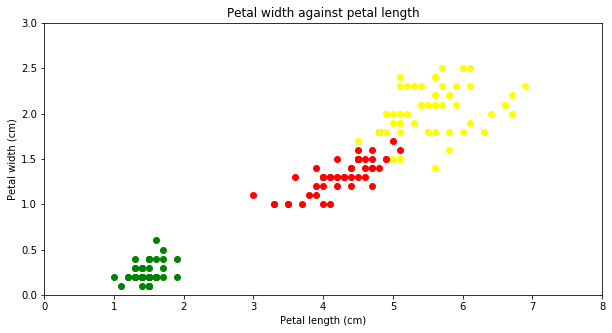

In [19]:
plengths = df["petal_length"]
pwidths = df["petal_width"]
labels = df["label"]

fig = plt.figure(figsize=(10,5))
plt.title("Petal width against petal length")
plt.scatter(plengths[labels=="Iris-setosa"], pwidths[labels=="Iris-setosa"], color = "green")
plt.scatter(plengths[labels=="Iris-versicolor"], pwidths[labels=="Iris-versicolor"], color = "red")
plt.scatter(plengths[labels=="Iris-virginica"], pwidths[labels=="Iris-virginica"], color = "yellow")
plt.xlabel("Petal length (cm)")
plt.xlim(0, 8)
plt.ylabel("Petal width (cm)")
plt.ylim(0, 3)
plt.show()

<ul>
    <li>Any observation you want to make?</li>
</ul>

<ul>
    <li>For the hell of it, we'll fit two multinomial logistic regression models: 
        <ul>
            <li>One-versus-rest</li>
            <li>Cross entropy</li>
        </ul>
        and use a majority-class classifier (although we don't need to. Why?)
    </li>
    <li>Note: scikit-learn wants the class labels to be integers
        <ul>
            <li>In the <i>CS1109</i> dataset, they were already 0 or 1</li>
            <li>In the Iris dataset, we must convert from "Iris-setosa", "Iris-versicolor" and "Iris-virginica" to 0, 1, 2</li>
            <li>Note: we do <strong>not</strong> usually one-hot encode class labels</li>
            <li>We use <code>LabelEncoder</code></li>
        </ul>
    </li>
</ul>

In [20]:
y = df["label"].values

encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

In [21]:
# The features we want to select
features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

# Create the one-versus-rest pipeline
ovr_pipeline = Pipeline([
        ("selector", DataFrameSelector(features)),
        ("scaler", StandardScaler()),
        ("estimator", LogisticRegression())
    ])

# Create the cross-entropy pipeline
cent_pipeline = Pipeline([
        ("selector", DataFrameSelector(features)),
        ("scaler", StandardScaler()),
        ("estimator", LogisticRegression(multi_class="multinomial", solver="newton-cg"))
    ])

# Create the classifier
maj_pipeline = Pipeline([
        ("selector", DataFrameSelector(features)),    
        ("estimator", DummyClassifier(strategy = "most_frequent"))
    ])

In [22]:
print("One-versus-Rest: ", np.mean(cross_val_score(ovr_pipeline, df, y_encoded, scoring="accuracy", cv=10)))
print("Cross entropy: ", np.mean(cross_val_score(cent_pipeline, df, y_encoded, scoring="accuracy", cv=10)))
print("Majority-class classifier: ", np.mean(cross_val_score(maj_pipeline, df, y_encoded, scoring="accuracy", cv=10)))

One-versus-Rest:  0.893333333333
Cross entropy:  0.953333333333
Majority-class classifier:  0.333333333333
